In [1]:
import os, sys
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [2]:
import demes, demesdraw, sparse
import matplotlib.pyplot as plt
import numpy as np

from momi3.Params import Params
from momi3.MOMI import Momi

from scipy import stats, optimize
import numpy as np
import jax.numpy as jnp
import jax
jax.config.update('jax_platform_name', 'cpu')

# Load

<AxesSubplot:ylabel='time ago (generations)'>

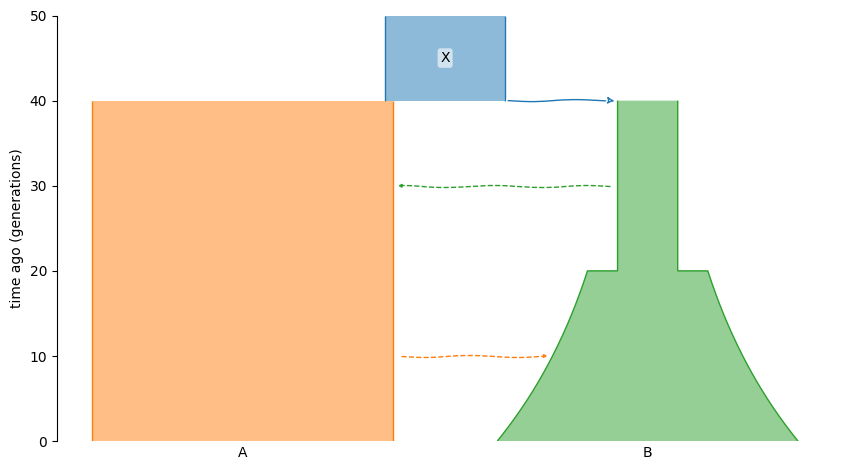

In [3]:
# Load demes graph
demo = demes.load(f"TwoDemes/TwoDemes.yml")
demesdraw.tubes(demo)

In [4]:
sampled_demes = ["A", "B"]
sample_sizes = [10, 16]

In [5]:
# Construct momi
momi = Momi(demo, sampled_demes=sampled_demes, sample_sizes=sample_sizes, jitted=True)

In [6]:
sfs_spec_momi = momi.sfs_spectrum()

In [7]:
sfs_spec_momi /= sfs_spec_momi.sum()

In [8]:
jsfs = momi.simulate(1000, seed=108)#sparse.load_npz("TwoDemes/TwoDemes.npz")

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
jsfs

Format,coo
Data Type,int64
Shape,"(11, 17)"
nnz,136
Density,0.7272727272727273
Read-only,True
Size,3.2K
Storage ratio,2.2


/tmp/ipykernel_696742/2959819326.py:2: RuntimeWarning: divide by zero encountered in log
  ax1.imshow(np.log(sfs_spec_momi))
/tmp/ipykernel_696742/2959819326.py:3: RuntimeWarning: divide by zero encountered in log
  ax2.imshow(np.log(jsfs.todense()))


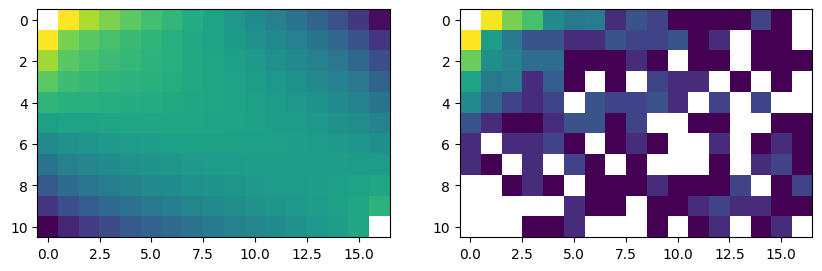

In [10]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.imshow(np.log(sfs_spec_momi))
ax2.imshow(np.log(jsfs.todense()))

In [11]:
params = Params(momi)

In [12]:
# Set the parameters you want to infer
params.set_train("eta_3", True)
params.set_train("eta_1", True)
params.set_train("pi_0", True)
params.set_train("pi_1", True)
params.set_train("tau_4", True)

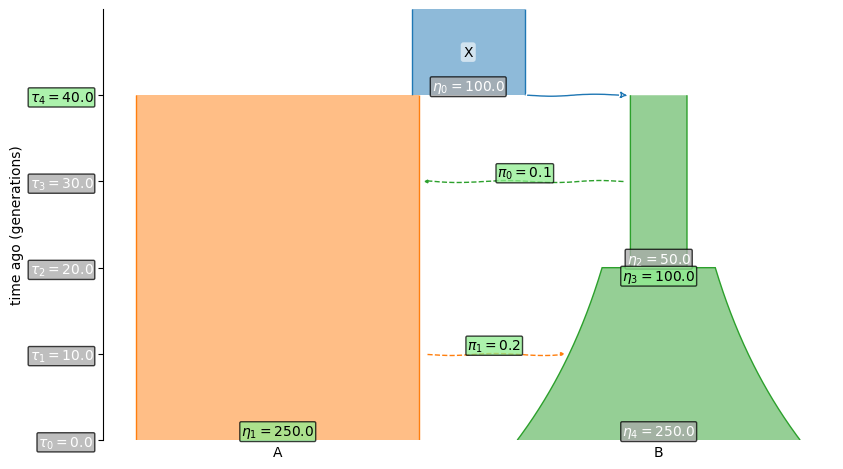

In [13]:
params.tubes(show_letters=True)

## profile likelihood example

In [162]:
# Normal


In [163]:
def gen_sym_cov_matrix(p, corr):
    Sigma = np.ones((p, p)) * corr
    Sigma += np.diag(p * [1 - corr])
    return Sigma

In [164]:
def model(b, X):
    return X @ b

In [165]:
n = 100
p = 10
corr = 0.8

b = np.random.randn(p)

np.random.seed(108)

X = stats.multivariate_normal(mean=p * [0], cov=gen_sym_cov_matrix(p, corr)).rvs(n)
eps = stats.norm(0, np.sqrt(p)*0.4).rvs(n)
y = model(b, X) + eps

In [166]:
@jax.jit
def loglik(b, X, y):
    yhat = model(b, X)
    return jnp.sum(jnp.power(y - yhat, 2))

jvag = jax.value_and_grad(loglik)

def f(b, X, y, out=None):
    v, g = jvag(b, X, y)
    if out is None:
        pass
    else:
        g = g.at[out].set(0.)
    return v, g

fun = lambda b: f(b, X, y, out=0)

In [167]:
def get_mle(b, out_index=None, out_val=None):
    b = b.copy()
    b1 = out_index is None
    b2 = out_val is None
    
    if b1 and b2:
        # General MLE
        fun = lambda b: f(b, X, y)
    elif not b1 and not b2:
        b[out_index] = out_val
        fun = lambda b: f(b, X, y, out=out_index)
    else:
        raise ValueError("Wrong Config")
        
    opt_res = optimize.minimize(fun, jac=True, x0=b, method='SLSQP')    
    return opt_res

In [168]:
mle_res = get_mle(b)

mle_loglik = -mle_res.fun
b_hat = mle_res.x

b_hat0 = b_hat[0]

In [20]:
H = jax.hessian(loglik)(b_hat, X, y)
std_error = np.sqrt(np.diag(np.linalg.pinv(H)))
std0 = std_error[0]
rv = stats.norm(loc=b_hat0, scale=std0)

In [21]:
xlim = [b_hat0 - 3*std0, b_hat0 + 3*std0]
b_0s = np.linspace(xlim[0], xlim[1], 50)

logliks = np.array([-get_mle(b, 0, b_0).fun for b_0 in b_0s])

In [22]:
myhline = mle_loglik - 2

In [23]:
sorted_ind = np.argsort(np.abs(logliks - myhline))
v1 = sorted_ind[0]
for i, val in enumerate(sorted_ind[1:]):
    if abs(v1 - val) == (i + 1):
        pass
    else:
        v2 = val
        break

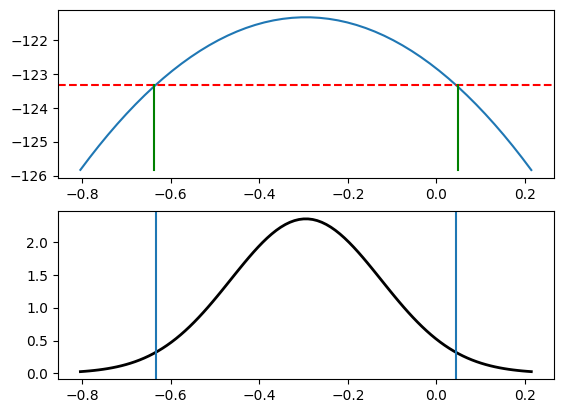

In [24]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(b_0s, logliks)
axs[0].axhline(myhline, color='red', linestyle='dashed')
axs[0].plot([b_0s[v1], b_0s[v1]], [myhline, min(logliks)], color = 'green')
axs[0].plot([b_0s[v2], b_0s[v2]], [myhline, min(logliks)], color = 'green')

x = np.linspace(xlim[0], xlim[1], 100)
axs[1].plot(x, rv.pdf(x), 'k-', lw=2)
axs[1].axvline(b_hat0 - 2*std0)
axs[1].axvline(b_hat0 + 2*std0)

# Profile Likelihood for Demo Params

In [14]:
def LOO_optimization(params, out_key=None, value=None, initial_tr_radius=0.01):
    # Leave-one-out Optimization
    
    if out_key is not None:
        orig_train_it = params[out_key].train_it
        params.set_train(out_key, False)
        params.set(out_key, value)    

    theta_train_0 = np.array(params._theta_train)
    train_keys = params._train_keys
    
    def fun(theta_train):

        theta_train_dict = {}
        for key, val in zip(train_keys, theta_train):
            theta_train_dict[key] = float(val)
        val, grad = momi.negative_loglik_with_gradient(
            params, jsfs, theta_train_dict, return_array=True
        )
            
        return val, grad
    
    
    method = "trust-constr"
    optimizer_options = dict(initial_tr_radius=initial_tr_radius)
    LinearConstraints = params._linear_constraints_for_scipy()   
       
    # Running the scipy optimizer
    res = optimize.minimize(
        fun=fun,
        x0=theta_train_0,
        jac=True,
        constraints=LinearConstraints,
        method=method,
        options=optimizer_options,
    )
    
    if out_key is not None:
        params.set_train(out_key, orig_train_it)
    
    res.x = dict(zip(train_keys, res.x))
    return res
    

In [15]:
ret = LOO_optimization(params, initial_tr_radius=1e-3)
print(f'loglik = {-ret.fun}')
print('Estimates:')
[print(f'{key}: {ret.x[key]:.2f}') for key in ret.x];

/home/enes/enesenv/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


loglik = -3331.4326171875
Estimates:
eta_1: 253.21
eta_3: 98.37
pi_0: 0.00
pi_1: 0.22
tau_4: 73.53


In [16]:
ret_loo = LOO_optimization(params, 'pi_1', 0.25, initial_tr_radius=1e-3)
print(f'loglik = {-ret_loo.fun}')
print('Estimates:')
[print(f'{key}: {ret_loo.x[key]:.2f}') for key in ret_loo.x];

loglik = -3331.7763671875
Estimates:
eta_1: 249.52
eta_3: 99.10
pi_0: 0.00
tau_4: 78.64


In [18]:
params.set_optimization_results(ret.x)

In [19]:
uncerts = momi.GIM_uncert(params, jsfs)

In [20]:
key = 'pi_1'

PE = params[key].num
SE = uncerts[key]

# "poor man’s profiles"
Learn more: https://kingaa.github.io/sbied/

In [21]:
lins = np.linspace(
    PE - 20 * SE,
    PE + 20 * SE,
    21
)

In [22]:
params.set_train('pi_0', False)

In [23]:
ell_mle = -ret.fun

In [24]:
ells = []
for val in lins:
    params.set(key, val)
    ell = momi.loglik_with_gradient(params, jsfs)[0]
    ells.append(ell)

In [25]:
LB, UB = PE - 2 * SE, PE + 2 * SE

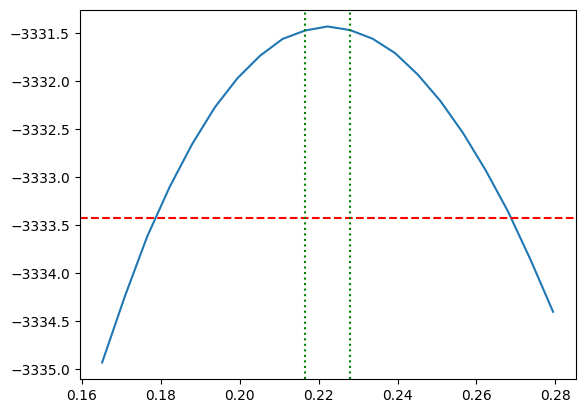

In [26]:
plt.plot(lins, ells)
plt.axhline(ell_mle - 2, color='red', linestyle='--')
plt.axvline(LB, linestyle=':', color='green')
plt.axvline(UB, linestyle=':', color='green')

In [81]:
rets = [LOO_optimization(params, key, val, initial_tr_radius=0.001) for val in lins]

/home/enes/enesenv/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/home/enes/enesenv/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '
/home/enes/enesenv/lib/python3.10/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead o

In [82]:
ells_pl = [-ret.fun for ret in rets]

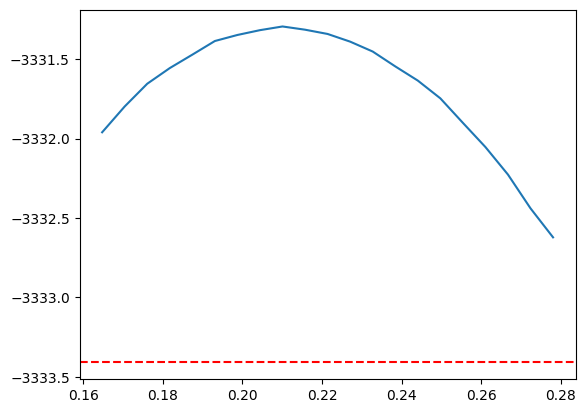

In [83]:
plt.plot(lins, ells_pl)
plt.axhline(ell_mle - 2, color='red', linestyle='--')